In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import h5py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from uatu.scattering import *
from kymatio import Scattering2D

In [5]:
from scipy import fftpack
from scipy.ndimage import gaussian_filter
import numpy as np
import pylab as py
#import radialProfile
from scipy.fftpack import fft2

In [6]:
model_path = '/home/sean/Git/uatu/networks/gupta_net_smooth_0_epoch_30.pth'

In [7]:
#mode = 2
mode = 0
#max_order = 2
max_order = 0

#J = 2
J = 0
L = 8
K = int(1 + L*J +(L**2)*(J*(J-1))/2.0)

width = 2
smooth = 0
shape = (256, 256)

In [8]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
scattering = lambda x: x
#scattering = lambda x: gaussian_filter(x, 1)

In [10]:
model = GuptaNet(1).to(device)

In [11]:
model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

In [12]:
model.eval()

GuptaNet(
  (layer_0): BasicBlock(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer_1): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer_2): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Linear(in_features=131072, out_features=256, bias=T

In [13]:
def log_barrier(x_p, x_o, eps=2., lam=1e6):
    # TODO, in pytorch
    norm = (x_p - x_o).norm(p=float('Inf')) + 1e-6

    assert norm < eps
    return -torch.log(eps - norm )/lam

In [14]:
def get_embedding(x, model):

    x = x.view(1, model.K, model.input_size, model.input_size)#

    for i, l in enumerate(model.layers):
        x = l(x)


    x = x.view(x.size(0), -1)
    #print(x.shape)
    x = model.fc1(x)
    #print(x.shape)
    x = model.fc2(x)
    #print(x.shape)
    
    return x

In [15]:
def fgsm_attack(image, eps, data_grad):
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image - eps*sign_data_grad
    #perturbed_image = image - eps*data_grad/(data_grad.sum()/(256))

    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [16]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    #print(deltar.shape)
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [17]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=4*deg)
    _, psd1D = cmap.powerSpectrum(l)
    '''
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)

    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift( F1 )

    # Calculate a 2D power spectrum
    psd2D = np.abs( F2 )**2

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(psd2D)
    '''
    return psd1D#/psd1D[0]

In [18]:
def plot_ps(X_orig, X_target, X_attack):
    
    X_orig = X_orig.data.to('cpu').numpy()
    X_target = X_target.data.to('cpu').numpy()
    X_attack = X_attack.data.to('cpu').numpy()

    attacked_ps = image_ps(X_attack.squeeze())
    target_ps = image_ps(X_target.squeeze())
    normal_ps = image_ps(X_orig.squeeze())
    diff_ps = image_ps((X_attack.squeeze()- X.squeeze()).squeeze())
    
    #fig = plt.figure(figsize = (8, 12))
    #plt.subplot(211)
    plt.plot(attacked_ps, label = 'Attacked' )
    plt.plot(target_ps, label = 'Target')
    plt.plot(normal_ps, label = 'Original')
    #plt.plot(diff_ps, label = 'Diff')

    plt.legend(loc='best')
    plt.loglog();
    #plt.subplot(212)
    #plt.title("Attacked/Normal")
    #plt.plot(attacked_ps/normal_ps, label = 'Attacked')
    #plt.plot(target_ps/normal_ps, label = 'Target')
    #plt.legend(loc='best')
    #plt.ylim([0.4, 6])
    #plt.loglog();
    plt.show();

In [19]:
def compute_robust_map(model, x0, xt): #use_log_barrier = True, log_eps = 1.5)

    # Send the data and label to the device
    x0, xt = x0.to(device), xt.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    perturbed_x0 = x0.clone()

    perturbed_x0.requires_grad = True
    scattering.requires_grad = False
    # Forward pass the data through the model
    init_pred = get_embedding(xt, model)
    #init_fft = 2*torch.log(torch.abs(torch.rfft(xt.squeeze(), 2)))
    # Calculate the 6oss
    epsilon =1e-4

    for i in range(500):
        output = get_embedding(perturbed_x0, model)
        # TODO put power spectrum here too? 
        loss = (output-init_pred).norm() + log_barrier(perturbed_x0, x0) #+ (init_fft - torch.log(torch.abs(torch.rfft(perturbed_x0.squeeze(), 2)))).norm() #- log_barrier(perturbed_x0, xt)
        #print( (output-init_pred).norm(), log_barrier(perturbed_x0, xt))
        print(loss)
        # Zero all existing gradients
        model.zero_grad()
        # Calculate gradients of model in backward pass
        loss.backward(retain_graph = True)

        # Collect datagrad

        x0_grad = perturbed_x0.grad.data
        # Call FGSM Attack
        if i%100 == 0:
            print('*'*20, i, '*'*20)
            epsilon= epsilon*0.9
            print('e', epsilon)
            plot_ps(x0, xt, perturbed_x0)
            plt.imshow(perturbed_x0.data.to('cpu').numpy().squeeze())
            plt.show();
            
        perturbed_x0 = fgsm_attack(perturbed_x0, epsilon, x0_grad)
        
        perturbed_x0 = torch.autograd.Variable(perturbed_x0.data, requires_grad=True)

    return perturbed_x0, init_pred, output

In [20]:
def count_peaks(im, size = 1):
    # i don't know if there's a faster way to do this but alas
    peak_idxs = np.zeros_like(im, dtype = bool)
    for i in range(size, im.shape[0]-size):
        for j in range(size, im.shape[1]-size): # no peaks on the boundaries i declare
            block = im[i-size:i+size+1, j-size:j+size+1].flatten()
            if np.all(im[i,j] >= block):
                peak_idxs[i,j] = True
    return im[peak_idxs]

In [21]:
with h5py.File('../data/UatuLightconeTraining.hdf5', 'r') as f:
    mean, std =  f.attrs['mean'], f.attrs['std']

In [22]:
from uatu.watchers.Dataset import *
transform = lambda x : torch.Tensor(gaussian_filter(x, smooth))
#transform = torch.Tensor

train_dset = DatasetFromFile('../data/UatuLightconeTest.hdf5',1, shuffle=True, augment=False, train_test_split = 0.8,\
                                 whiten = True, cache_size = 100, transform=transform)
test_dset = train_dset.get_test_dset() 

failed


In [23]:
preds = []
truths = []
for batch_idx, (X, Y) in enumerate(test_dset):
    #print(batch_idx,)
    preds.append(model(scattering(X.to('cuda'))).to('cpu').detach().numpy().squeeze())
    truths.append(Y)
    #print(preds[-1], Y)

In [24]:
preds = np.array(preds).reshape((-1, 2))
truths = np.array([np.array(t) for t in truths]).reshape((-1, 2))

print( (np.abs(preds-truths)/truths).mean(axis=0))

[0.05837171 0.04073793]


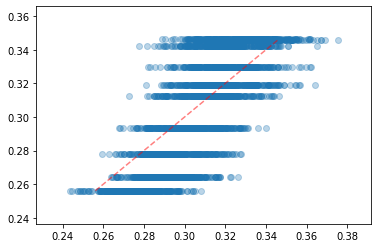

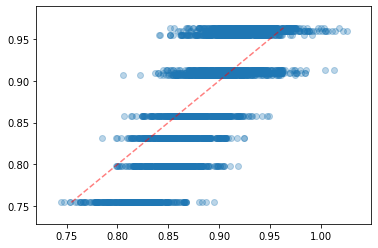

In [25]:
plt.scatter(preds[:,0], truths[:,0], alpha = 0.3)
plt.plot(sorted(truths[:,0]),sorted(truths[:,0]), ls = '--', color = 'r', alpha = 0.5 )
plt.show();
plt.scatter(preds[:,1], truths[:,1], alpha = 0.3)

plt.plot(sorted(truths[:,1]),sorted(truths[:,1]), ls = '--', color = 'r', alpha = 0.5 )
plt.show();

In [26]:
f = h5py.File('../data/UatuLightconeSameSeed.hdf5', 'r')
#for boxno in xrange(5):
boxno = 2
target_boxno = 3
test_X = np.array(f['Box%03d'%boxno]["X"][()])
test_Y = f['Box%03d'%boxno]['Y'][0].reshape((1,2))

target_X = np.array(f['Box%03d'%target_boxno]["X"][()])
target_Y = f['Box%03d'%target_boxno]['Y'][0].reshape((1,2))
f.close()

In [27]:
test_X = (test_X-mean)/(std)
target_X = (target_X-mean)/(std)

In [28]:
n_orig = 100 #201#100 
n_targ = n_orig#201
batch_size = 1 

X = test_X[n_orig, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))
X = np.tile(X, (batch_size, 1, 1, 1) )
Y = test_Y[0, :].reshape((1, test_Y.shape[1]))
Y = np.tile(Y, (batch_size, 1))

In [29]:
np.random.seed(32)
X = np.random.randn(*X.shape)#*X.std() + X.mean()

In [30]:
targ_X = target_X[n_targ, :, :, :].reshape((1, test_X.shape[1],\
                                test_X.shape[2], test_X.shape[3]))

#targ_X = (targ_X-mean)/(std)

In [31]:
from astropy.units import deg

from lenstools import GaussianNoiseGenerator, ConvergenceMap

#Set map side angle, and number of pixels on a side
num_pixel_side = shape[0]
side_angle = 4 * deg

#Read the power spectrum (l,Pl) from an external file, and load it in numpy array format (the generator interpolates the power spectrum between bins)
Pl = image_ps(targ_X.squeeze())

In [32]:
#90% sure this is right
l = np.linspace(128, 128*128, Pl.shape[0]+1)

In [33]:
cmap = ConvergenceMap(gaussian_filter(targ_X.squeeze(), smooth), angle=side_angle)
l2, Pl2 = cmap.powerSpectrum(l)

In [34]:
X = (X- X.mean())/(X.std())*targ_X.std()+targ_X.mean()

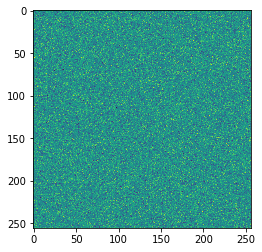

In [35]:
plt.imshow(X.squeeze())

tensor(0.9606, device='cuda:0', grad_fn=<AddBackward0>)
******************** 0 ********************
e 9e-05


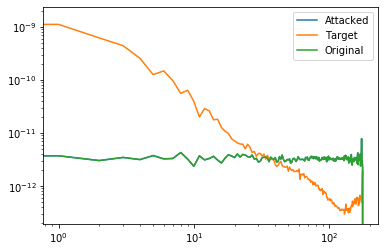

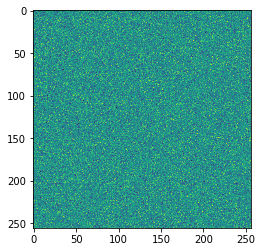

tensor(0.8109, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5679, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4070, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3463, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2958, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2389, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2292, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2200, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2112, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2061, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1986, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1957, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1895, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1821, device='cuda:0', grad_fn=<AddBack

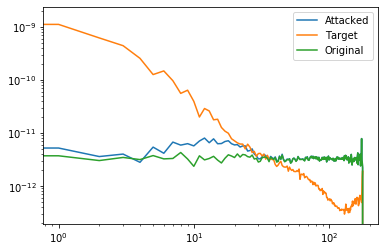

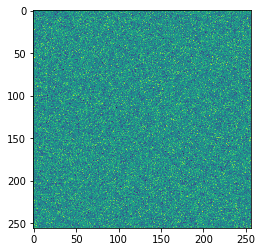

tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1052, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1142, device='cuda:0', grad_fn=<AddBack

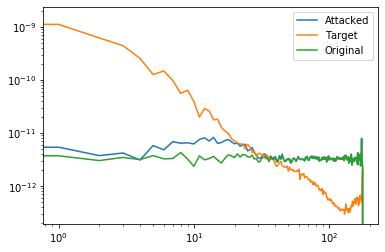

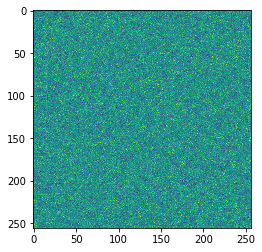

tensor(0.0818, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1011, device='cuda:0', grad_fn=<AddBack

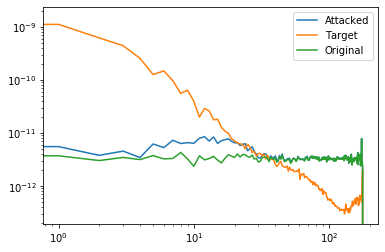

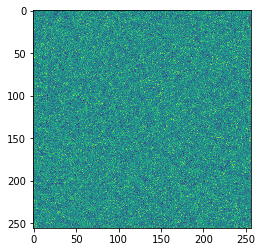

tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0934, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0914, device='cuda:0', grad_fn=<AddBack

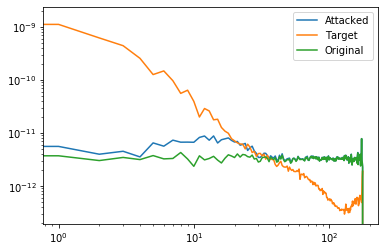

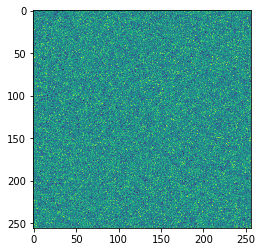

tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0865, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0865, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0872, device='cuda:0', grad_fn=<AddBack

In [36]:
X_robust, init_embed, robust_embed = compute_robust_map(model,\
                                  torch.Tensor(X).reshape((1, shape[0], shape[1])), \
                                torch.Tensor(gaussian_filter(targ_X,smooth)).reshape((1, shape[0], shape[1])) )#,\

In [37]:
X_robust = X_robust.to('cpu').detach().numpy().squeeze()
init_embed = init_embed.to('cpu').detach().numpy().squeeze()
robust_embed = robust_embed.to('cpu').detach().numpy().squeeze()

In [38]:
init_embed.shape

(256,)

In [39]:
def get_embedding_2(x, model):
    x = scattering(x)

    x = x.view(1, model.K, model.input_size, model.input_size)#
############# UNCOMMENT ME ################
    x = model.init_conv(x)

    for i,l in enumerate(model.layers):
        #if i ==1:
        #    break
        x = l(x)
    
    return x

In [40]:
print(np.linalg.norm(init_embed-robust_embed))

0.054748595


In [41]:
X_robust.max(), X.max()

(0.17835772, 0.17691766543333)

In [42]:
vmin = min(X.min(), targ_X.min())
vmax = max(X.max(), targ_X.max())

In [43]:
target_Y

array([[0.350059, 0.946085]])

In [44]:
model(scattering(torch.Tensor(gaussian_filter(targ_X.reshape((1, shape[0], shape[1])), 0)).to('cuda'))).to('cpu').detach().numpy()

array([[0.31951702, 0.9200598 ]], dtype=float32)

In [45]:
model(scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda'))).to('cpu').detach().numpy()

array([[0.31930336, 0.91915095]], dtype=float32)

In [46]:
orig_s = scattering(torch.Tensor(X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
robust_s = scattering(torch.Tensor(X_robust.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()
targ_s = scattering(torch.Tensor(targ_X.reshape((1, shape[0], shape[1]))).to('cuda')).to('cpu').detach().numpy()

In [47]:
np.linalg.norm(orig_s-targ_s), np.linalg.norm(robust_s-targ_s)

(2.3978426, 2.4311996)

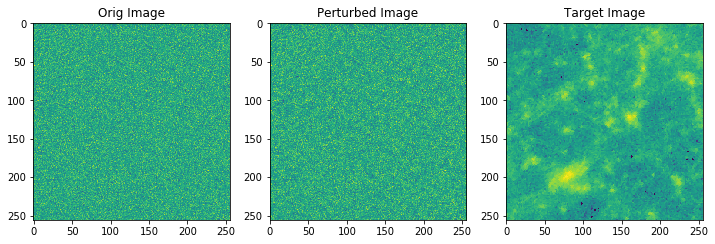

In [48]:
fig = plt.figure(figsize = (12,4))
plt.subplot(131)
plt.title('Orig Image')
plt.imshow(X.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(132)
plt.title('Perturbed Image')
plt.imshow(X_robust.squeeze(), vmin = vmin, vmax= vmax)
plt.subplot(133)
plt.title('Target Image')
plt.imshow(targ_X.squeeze(), vmin = vmin, vmax= vmax)

(7237,)
(12435,)
(7118,)


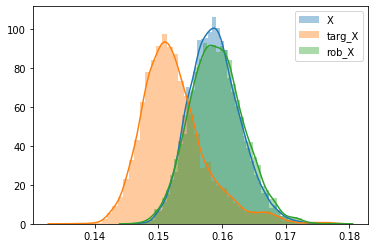

In [49]:
size = 1
orig_peaks = count_peaks(X.squeeze(), size = size)
print(orig_peaks.shape)
sns.distplot(orig_peaks,label = 'X');
targ_peaks = count_peaks(gaussian_filter(targ_X.squeeze(), smooth), size = size)
print(targ_peaks.shape)
sns.distplot(targ_peaks,label = "targ_X")
rob_peaks = count_peaks(X_robust.squeeze(), size = size)
print(rob_peaks.shape)
sns.distplot(rob_peaks,label = 'rob_X')
plt.legend(loc = 'best');

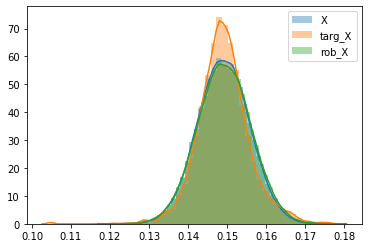

In [50]:
sns.distplot(X.flatten(), label = 'X')
sns.distplot(gaussian_filter(targ_X.flatten(), smooth), label = 'targ_X')
sns.distplot(X_robust.flatten(), label = 'rob_X')
plt.legend(loc='best')

---

In [51]:
attacked_ps = image_ps(X_robust.squeeze())
target_ps = image_ps(gaussian_filter(targ_X.squeeze(), smooth))
normal_ps = image_ps(X.squeeze())
diff_ps = image_ps((X_robust- X.squeeze()).squeeze())

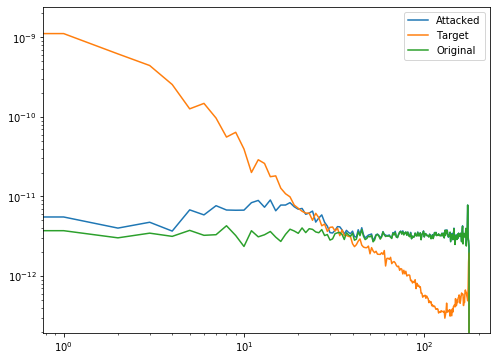

In [52]:
fig = plt.figure(figsize = (8, 6))
#plt.subplot(211)
plt.plot(attacked_ps, label = 'Attacked' )
plt.plot(target_ps, label = 'Target')
plt.plot(normal_ps, label = 'Original')
#plt.plot(diff_ps, label = 'Diff')

plt.legend(loc='best')
plt.loglog();
#plt.subplot(212)
#plt.title("Attacked/Normal")
#plt.plot(attacked_ps/normal_ps, label = 'Attacked')
#plt.plot(target_ps/normal_ps, label = 'Target')
#plt.legend(loc='best')
#plt.ylim([0.4, 6])
#plt.loglog();